In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os, zipfile, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from collections import Counter


In [7]:
# SMART EXTRACTION + FOLDER DETECTION FIX

import zipfile, shutil, os
from pathlib import Path

# Define paths
DATA_ROOT = Path("./data_extracted")
TRAIN_ZIP = "/content/train-20251105T052044Z-1-001.zip"
VALID_ZIP = "/content/valid-20251105T051947Z-1-001.zip"
TEST_ZIP  = "/content/test-20251105T051945Z-1-001.zip"

# Clean old extraction if exists
if DATA_ROOT.exists():
    shutil.rmtree(DATA_ROOT)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def smart_extract(zip_path, target_dir):
    """Extract zip and automatically detect the actual 'train/valid/test' folder level."""
    print(f"Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Extracted to {target_dir}")

    # Find the real dataset folder (contains class subfolders)
    # e.g., /data/train/train/...  or /data/train/...
    candidates = list(Path(target_dir).rglob("train"))
    if not candidates:
        candidates = list(Path(target_dir).rglob("Train"))
    if candidates:
        print(f"Found train folder candidate: {candidates[0]}")
    return target_dir

# Extract all datasets
smart_extract(TRAIN_ZIP, DATA_ROOT / "train")
smart_extract(VALID_ZIP, DATA_ROOT / "valid")
smart_extract(TEST_ZIP,  DATA_ROOT / "test")

# Detect the deepest actual directories that contain class folders
def find_actual_dataset_dir(base_dir):
    base_dir = Path(base_dir)
    subdirs = [p for p in base_dir.rglob("*") if p.is_dir() and any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in p.glob("*"))]
    if subdirs:
        # Return parent folder containing class folders
        parents = {p.parent for p in subdirs}
        best = min(parents, key=lambda p: len(p.parts))
        print(f"✅ Found valid dataset directory: {best}")
        return best
    else:
        print(f"⚠️ No images found under {base_dir}, check your zip structure.")
        return base_dir

TRAIN_DIR = find_actual_dataset_dir(DATA_ROOT / "train")
VALID_DIR = find_actual_dataset_dir(DATA_ROOT / "valid")
TEST_DIR  = find_actual_dataset_dir(DATA_ROOT / "test")

print(f"\nFinal dataset directories:")
print(f"Train dir: {TRAIN_DIR}")
print(f"Valid dir: {VALID_DIR}")
print(f"Test dir:  {TEST_DIR}")

# Quick verification
for root, dirs, files in os.walk(TRAIN_DIR):
    print(f"\nSample structure check:\n{root} -> {len(dirs)} class folders")
    print("Classes:", dirs)
    break

Extracting /content/train-20251105T052044Z-1-001.zip ...
Extracted to data_extracted/train
Found train folder candidate: data_extracted/train/train
Extracting /content/valid-20251105T051947Z-1-001.zip ...
Extracted to data_extracted/valid
Extracting /content/test-20251105T051945Z-1-001.zip ...
Extracted to data_extracted/test
✅ Found valid dataset directory: data_extracted/train/train
✅ Found valid dataset directory: data_extracted/valid/valid
✅ Found valid dataset directory: data_extracted/test/test

Final dataset directories:
Train dir: data_extracted/train/train
Valid dir: data_extracted/valid/valid
Test dir:  data_extracted/test/test

Sample structure check:
data_extracted/train/train -> 4 class folders
Classes: ['no_tumor', 'glioma', 'pituitary', 'meningioma']


In [8]:
!nvidia-smi


Sat Nov  8 05:26:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
# 1) CONFIG

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = Path("data_extracted_fixed")   # already extracted (from your previous step)
TRAIN_DIR = DATA_ROOT / "train" / "train"
VALID_DIR = DATA_ROOT / "valid" / "valid"
TEST_DIR  = DATA_ROOT / "test" / "test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
OUTPUT_DIR = Path("models_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

In [10]:
# 2️) DATA PREPROCESSING (Fixed for RGB inputs)

print("✅ Preparing datasets...")

def create_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        seed=SEED,
        color_mode="rgb"   # 👈 Force 3-channel RGB to avoid grayscale mismatch
    )
    return ds

train_ds = create_dataset(TRAIN_DIR)
val_ds   = create_dataset(VALID_DIR, shuffle=False)
test_ds  = create_dataset(TEST_DIR, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ✅ Sanity check: verify image shape
for images, labels in train_ds.take(1):
    print(f"Sample image batch shape: {images.shape}")
    print(f"Sample label batch shape: {labels.shape}")

# Normalize pixel values to [0–1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

✅ Preparing datasets...
Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Sample image batch shape: (32, 224, 224, 3)
Sample label batch shape: (32,)


In [11]:
# 3️) DATA AUGMENTATION

print("✅ Setting up augmentation...")
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

✅ Setting up augmentation...


In [12]:
# 4️) MODEL BUILDING (Fixed & Verified)

print("✅ Building models...")

# ---- Custom CNN ----
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

custom_cnn = build_custom_cnn((224,224,3), num_classes)
custom_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

# ---- Transfer Learning Models ----
def build_transfer_model(base_model, num_classes=4):
    base_model.trainable = False
    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

transfer_models = {
    "ResNet50": build_transfer_model(applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "MobileNetV2": build_transfer_model(applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "InceptionV3": build_transfer_model(applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
}

✅ Building models...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


✅ Training models...

Training CustomCNN ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4060 - loss: 1.6746

53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.4074 - loss: 1.6709 - val_accuracy: 0.3247 - val_loss: 1.3902
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.5666 - loss: 1.1474 - val_accuracy: 0.3725 - val_loss: 1.4102
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.5824 - loss: 1.1408 - val_accuracy: 0.4143 - val_loss: 1.5369
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.6133 - loss: 1.1269 - val_accuracy: 0.4940 - val_loss: 1.6573
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.6185 - loss: 1.0215 - val_accuracy: 0.5080 - val_loss: 1.5425


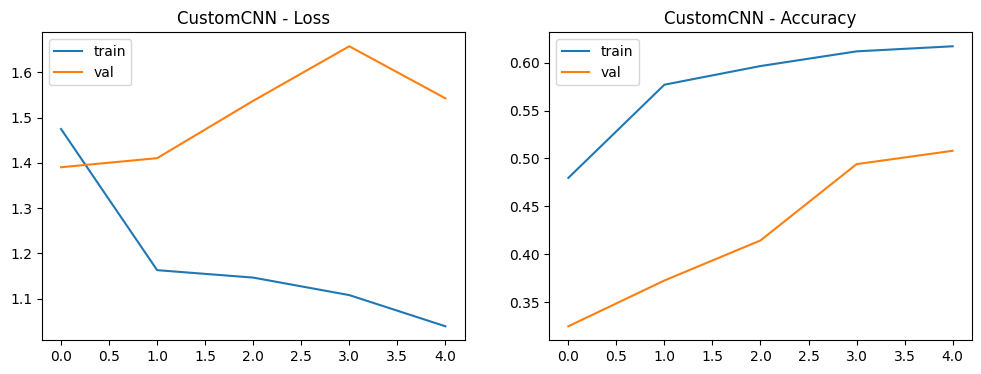


Training ResNet50 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3008 - loss: 1.8925

53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 257ms/step - accuracy: 0.3010 - loss: 1.8895 - val_accuracy: 0.3247 - val_loss: 1.5535
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3386 - loss: 1.4920

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.3383 - loss: 1.4919 - val_accuracy: 0.3566 - val_loss: 1.3618
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2850 - loss: 1.4866

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.2853 - loss: 1.4859 - val_accuracy: 0.3566 - val_loss: 1.3231
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3309 - loss: 1.4320

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.3306 - loss: 1.4320 - val_accuracy: 0.3865 - val_loss: 1.3099
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3083 - loss: 1.4180

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.3085 - loss: 1.4179 - val_accuracy: 0.4243 - val_loss: 1.3015
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3474 - loss: 1.3790

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.3474 - loss: 1.3790 - val_accuracy: 0.4303 - val_loss: 1.2915
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3379 - loss: 1.4036

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.3380 - loss: 1.4036 - val_accuracy: 0.4283 - val_loss: 1.2810
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3596 - loss: 1.3607

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.3594 - loss: 1.3610 - val_accuracy: 0.4223 - val_loss: 1.2733
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3304 - loss: 1.3813

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.3304 - loss: 1.3813 - val_accuracy: 0.4641 - val_loss: 1.2679
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3330 - loss: 1.3871

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.3332 - loss: 1.3866 - val_accuracy: 0.4243 - val_loss: 1.2577
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3644 - loss: 1.3371

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.3647 - loss: 1.3371 - val_accuracy: 0.5040 - val_loss: 1.2512
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3360 - loss: 1.3592

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.3363 - loss: 1.3590 - val_accuracy: 0.4801 - val_loss: 1.2444
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3662 - loss: 1.3187

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 0.3663 - loss: 1.3188 - val_accuracy: 0.4602 - val_loss: 1.2371
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.4056 - loss: 1.3004

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.4054 - loss: 1.3005 - val_accuracy: 0.5239 - val_loss: 1.2338
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3911 - loss: 1.3158

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.3909 - loss: 1.3161 - val_accuracy: 0.4522 - val_loss: 1.2226


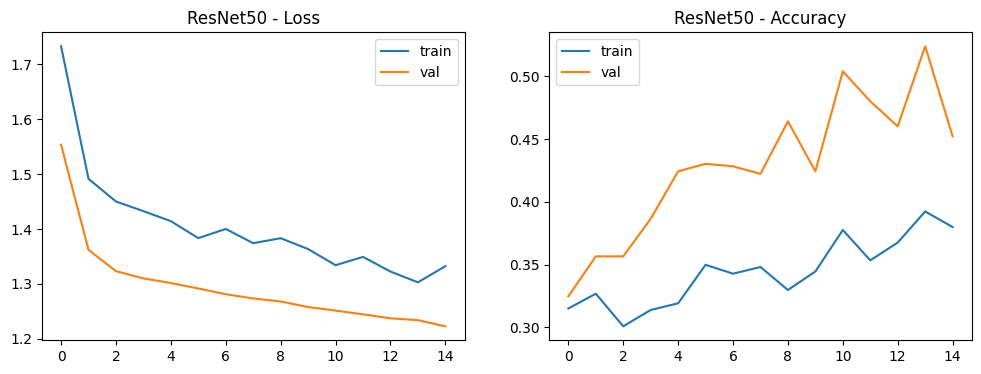


Training MobileNetV2 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2985 - loss: 1.5945

53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.2996 - loss: 1.5921 - val_accuracy: 0.4203 - val_loss: 1.2602
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4553 - loss: 1.2792

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.4554 - loss: 1.2786 - val_accuracy: 0.5139 - val_loss: 1.1316
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5222 - loss: 1.1544

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5224 - loss: 1.1535 - val_accuracy: 0.5538 - val_loss: 1.0488
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5807 - loss: 1.0315

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.5807 - loss: 1.0313 - val_accuracy: 0.5777 - val_loss: 0.9840
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6226 - loss: 0.9641

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.6227 - loss: 0.9637 - val_accuracy: 0.6016 - val_loss: 0.9236
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6330 - loss: 0.8915

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.6332 - loss: 0.8914 - val_accuracy: 0.6155 - val_loss: 0.8784
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6702 - loss: 0.8667

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.6701 - loss: 0.8665 - val_accuracy: 0.6355 - val_loss: 0.8437
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7014 - loss: 0.7889

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7011 - loss: 0.7892 - val_accuracy: 0.6514 - val_loss: 0.8163
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7100 - loss: 0.7708

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.7098 - loss: 0.7710 - val_accuracy: 0.6554 - val_loss: 0.7929
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6940 - loss: 0.7771

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.6942 - loss: 0.7765 - val_accuracy: 0.6713 - val_loss: 0.7740
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7511 - loss: 0.6856

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.7509 - loss: 0.6860 - val_accuracy: 0.6713 - val_loss: 0.7555
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7268 - loss: 0.6866

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7269 - loss: 0.6867 - val_accuracy: 0.6972 - val_loss: 0.7274
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.7233 - loss: 0.7076 - val_accuracy: 0.7012 - val_loss: 0.7274
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7364 - loss: 0.7092

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7367 - loss: 0.7082 - val_accuracy: 0.6952 - val_loss: 0.7258
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7354 - loss: 0.6642

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.7357 - loss: 0.6637 - val_accuracy: 0.7151 - val_loss: 0.7017


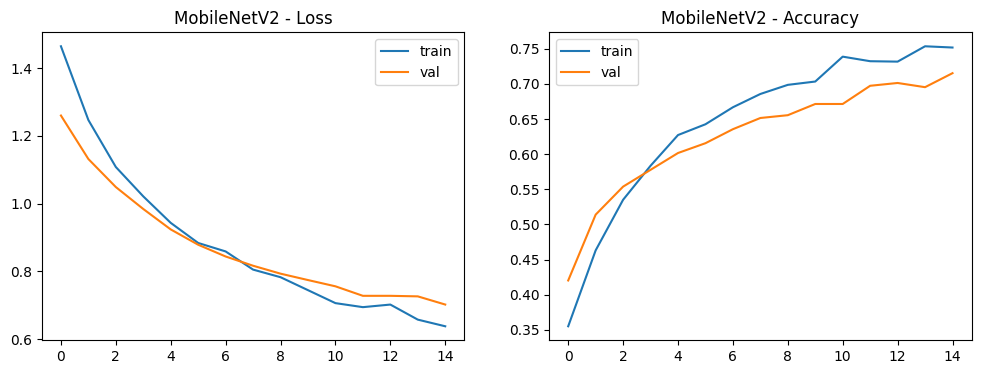


Training InceptionV3 ...
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.3133 - loss: 1.4976

53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.3141 - loss: 1.4964 - val_accuracy: 0.4900 - val_loss: 1.2173
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4539 - loss: 1.2207

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.4543 - loss: 1.2201 - val_accuracy: 0.5677 - val_loss: 1.0760
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5165 - loss: 1.1664

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.5171 - loss: 1.1652 - val_accuracy: 0.5976 - val_loss: 0.9948
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5781 - loss: 1.0149

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.5782 - loss: 1.0145 - val_accuracy: 0.6295 - val_loss: 0.9098
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6050 - loss: 0.9746

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.6052 - loss: 0.9741 - val_accuracy: 0.6315 - val_loss: 0.8837
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6327 - loss: 0.8977

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.6331 - loss: 0.8972 - val_accuracy: 0.6574 - val_loss: 0.8330
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6986 - loss: 0.8155

53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.6983 - loss: 0.8158 - val_accuracy: 0.6673 - val_loss: 0.8064
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6922 - loss: 0.8037

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.6920 - loss: 0.8036 - val_accuracy: 0.6653 - val_loss: 0.8020
Epoch 9/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7109 - loss: 0.7440

53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.7109 - loss: 0.7441 - val_accuracy: 0.6873 - val_loss: 0.7540
Epoch 10/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6832 - loss: 0.7500

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.6835 - loss: 0.7499 - val_accuracy: 0.7032 - val_loss: 0.7293
Epoch 11/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.7311 - loss: 0.7058 - val_accuracy: 0.6952 - val_loss: 0.7486
Epoch 12/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7375 - loss: 0.6768

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.7376 - loss: 0.6769 - val_accuracy: 0.7191 - val_loss: 0.6954
Epoch 13/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.7233 - loss: 0.6963 - val_accuracy: 0.7092 - val_loss: 0.7079
Epoch 14/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.7440 - loss: 0.6781 - val_accuracy: 0.7072 - val_loss: 0.7112
Epoch 15/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7267 - loss: 0.6859

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.7269 - loss: 0.6857 - val_accuracy: 0.7131 - val_loss: 0.6785


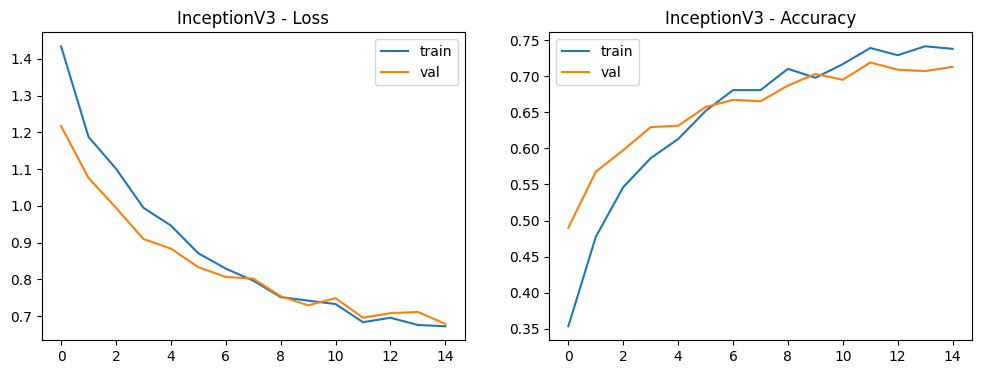

In [13]:
# 5️) MODEL TRAINING

print("✅ Training models...")
results = []

def train_model(model, name):
    print(f"\nTraining {name} ...")
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/{name}_best.h5", save_best_only=True)
    ]
    model.compile(optimizer=optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)
    # Plot history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{name} - Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{name} - Accuracy'); plt.legend()
    plt.show()
    return model, history

# Train Custom CNN
custom_cnn, history_cnn = train_model(custom_cnn, "CustomCNN")

# Train Transfer Models
for name, model in transfer_models.items():
    model, hist = train_model(model, name)
    transfer_models[name] = model

✅ Evaluating models...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


📊 CustomCNN Results:
Accuracy=0.3374  Precision=0.3113  Recall=0.3374  F1=0.1898
              precision    recall  f1-score   support

      glioma       0.34      1.00      0.51        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       1.00      0.06      0.12        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.34       246
   macro avg       0.34      0.27      0.16       246
weighted avg       0.31      0.34      0.19       246



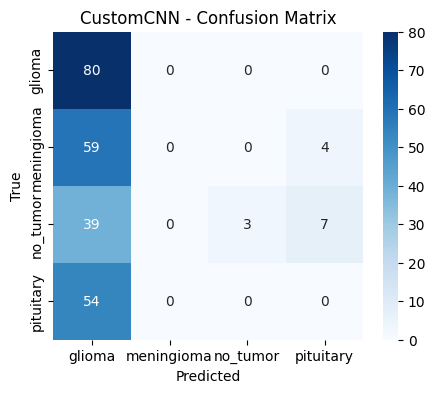


📊 ResNet50 Results:
Accuracy=0.4512  Precision=0.4704  Recall=0.4512  F1=0.3430
              precision    recall  f1-score   support

      glioma       0.40      1.00      0.57        80
  meningioma       0.60      0.05      0.09        63
    no_tumor       0.75      0.55      0.64        49
   pituitary       0.17      0.02      0.03        54

    accuracy                           0.45       246
   macro avg       0.48      0.40      0.33       246
weighted avg       0.47      0.45      0.34       246



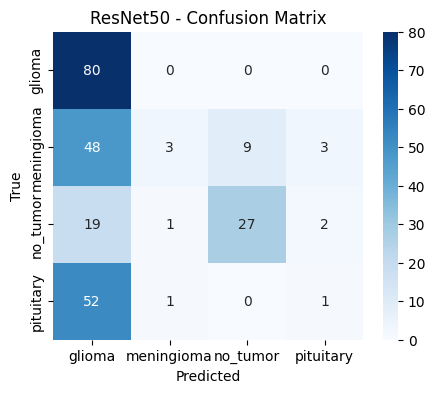


📊 MobileNetV2 Results:
Accuracy=0.7073  Precision=0.7520  Recall=0.7073  F1=0.7061
              precision    recall  f1-score   support

      glioma       0.90      0.75      0.82        80
  meningioma       0.64      0.46      0.54        63
    no_tumor       0.89      0.65      0.75        49
   pituitary       0.54      0.98      0.70        54

    accuracy                           0.71       246
   macro avg       0.74      0.71      0.70       246
weighted avg       0.75      0.71      0.71       246



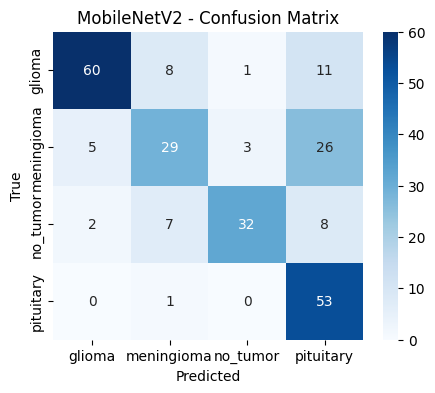


📊 InceptionV3 Results:
Accuracy=0.6951  Precision=0.7123  Recall=0.6951  F1=0.6752
              precision    recall  f1-score   support

      glioma       0.78      0.78      0.78        80
  meningioma       0.72      0.33      0.46        63
    no_tumor       0.70      0.71      0.71        49
   pituitary       0.60      0.98      0.75        54

    accuracy                           0.70       246
   macro avg       0.70      0.70      0.67       246
weighted avg       0.71      0.70      0.68       246



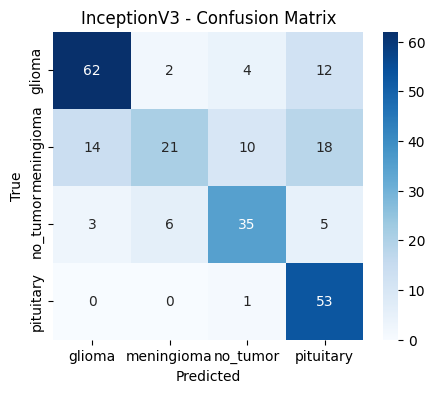

In [14]:
# 6️) MODEL EVALUATION

print("✅ Evaluating models...")

def evaluate_model(model, name):
    y_true, y_pred = [], []
    for imgs, labels in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"\n📊 {name} Results:")
    print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# Evaluate all models
results.append(evaluate_model(custom_cnn, "CustomCNN"))
for name, model in transfer_models.items():
    results.append(evaluate_model(model, name))




✅ Model Comparison Summary:
         model  accuracy  precision    recall        f1
2  MobileNetV2  0.707317   0.752038  0.707317  0.706063
3  InceptionV3  0.695122   0.712310  0.695122  0.675232
1     ResNet50  0.451220   0.470369  0.451220  0.342953
0    CustomCNN  0.337398   0.311326  0.337398  0.189754


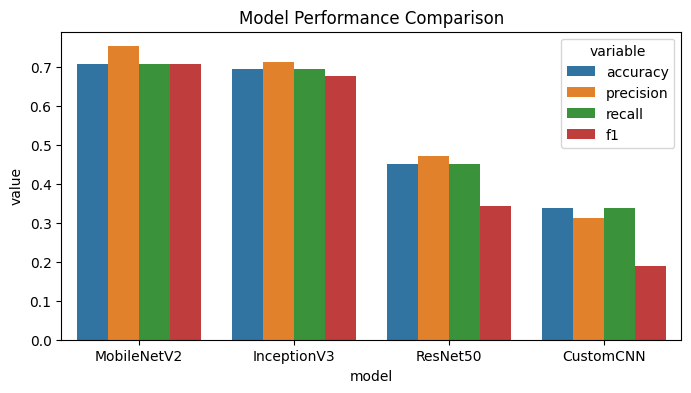


🏆 Best Performing Model: MobileNetV2


In [15]:
# 7️) MODEL COMPARISON

df = pd.DataFrame(results).sort_values("f1", ascending=False)
print("\n✅ Model Comparison Summary:")
print(df)

plt.figure(figsize=(8,4))
sns.barplot(data=df.melt(id_vars='model', value_vars=['accuracy','precision','recall','f1']),
            x='model', y='value', hue='variable')
plt.title("Model Performance Comparison")
plt.show()

best_model_name = df.iloc[0]["model"]
print(f"\n🏆 Best Performing Model: {best_model_name}")


In [16]:
import pickle
from tensorflow.keras.models import load_model

# save to h5
best_model_path = f"models_outputs/{best_model_name}_best.h5"
best_model = load_model(best_model_path)

# Save to pickle
pickle_path = f"models_outputs/{best_model_name}_best.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Saved best model as: {pickle_path}")

✅ Saved best model as: models_outputs/MobileNetV2_best.pkl


In [18]:
!pip install streamlit-option-menu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.3/829.3 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 140.9 MB/s eta 0:00:00


In [21]:
# ============================================================
# 🧠 Brain Tumor Classification — Streamlit (for Google Colab)
# ============================================================
%%writefile /content/app.py
# (paste the full streamlit code here)

# ⚙️  STEP 1:  Install required libraries
!pip install -q streamlit tensorflow pillow numpy pyngrok

# ⚙️  STEP 2:  Import libraries
import os, json
import numpy as np
import tensorflow as tf
import streamlit as st
from PIL import Image
from pyngrok import ngrok

# ------------------------------------------------------------
# 🔧 CONFIGURATION
# ------------------------------------------------------------
st.set_page_config(page_title="Brain Tumor Classifier", page_icon="🧠", layout="centered")

MODEL_PATH = "/content/models_outputs/MobileNetV2_best.h5"  # <-- adjust if needed
IMG_SIZE   = (224, 224)
CLASS_NAMES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

st.title("🧠 Brain Tumor Classification")
st.write("Upload a **brain MRI image** below to classify the tumor type.")

# ------------------------------------------------------------
# 🧩 LOAD TRAINED MODEL
# ------------------------------------------------------------
@st.cache_resource(show_spinner=True)
def load_model(path: str):
    return tf.keras.models.load_model(path)

with st.sidebar:
    st.header("Model")
    st.caption("Ensure the model path exists below 👇")
    st.code(MODEL_PATH, language="text")

try:
    assert os.path.exists(MODEL_PATH), f"Model not found at:\n{MODEL_PATH}"
    model = load_model(MODEL_PATH)
    st.sidebar.success("✅ Model loaded successfully!")
except Exception as e:
    st.sidebar.error(f"❌ Model load failed:\n{e}")
    st.stop()

# ------------------------------------------------------------
# 🔧 HELPERS
# ------------------------------------------------------------
def preprocess_image(pil_img: Image.Image, target_hw=(224, 224)) -> np.ndarray:
    arr = np.array(pil_img.convert("RGB"))
    arr = tf.image.resize(arr, target_hw)
    arr = tf.cast(arr, tf.float32) / 255.0
    arr = tf.expand_dims(arr, 0)
    return arr.numpy()

def safe_softmax(vec: np.ndarray) -> np.ndarray:
    x = vec - np.max(vec, axis=-1, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=-1, keepdims=True)

# ------------------------------------------------------------
# 📤 IMAGE UPLOAD SECTION
# ------------------------------------------------------------
uploaded_file = st.file_uploader("Upload an MRI Image (jpg/png/jpeg)",
                                 type=["jpg","jpeg","png"])

if not uploaded_file:
    st.info("👆 Please upload a brain MRI image to begin prediction.")
    st.stop()

try:
    image = Image.open(uploaded_file).convert("RGB")
except Exception as e:
    st.error(f"Could not read the image file: {e}")
    st.stop()

st.image(image, caption="🩺 Uploaded MRI Image", use_container_width=True)

# ------------------------------------------------------------
# 🔮 PREDICT
# ------------------------------------------------------------
img_batch = preprocess_image(image, IMG_SIZE)

try:
    preds = model.predict(img_batch)
    preds = np.array(preds)
    if preds.ndim == 2 and (preds.min() < 0 or preds.max() > 1):
        preds = safe_softmax(preds)
except Exception as e:
    st.error(f"Prediction failed: {e}")
    st.stop()

if preds.ndim == 1:
    probs = preds
else:
    probs = preds[0]

pred_class = int(np.argmax(probs))
pred_label = CLASS_NAMES[pred_class] if len(CLASS_NAMES)==len(probs) else f"class_{pred_class}"
confidence = float(probs[pred_class])

# ------------------------------------------------------------
# 🎯 DISPLAY PREDICTION RESULTS
# ------------------------------------------------------------
st.subheader("🧾 Prediction Results")
st.success(f"**Predicted Tumor Type:** {pred_label}")
st.write(f"**Confidence:** {confidence*100:.2f}%")

st.markdown("### 🔍 Model Confidence per Class")
conf_data = { (CLASS_NAMES[i] if i < len(CLASS_NAMES) else f"class_{i}") : float(probs[i])
              for i in range(len(probs)) }
st.bar_chart(conf_data)

result = {
    "predicted_label": pred_label,
    "confidence": confidence,
    "per_class": conf_data,
}
st.download_button("⬇️ Download result (JSON)",
                   data=json.dumps(result, indent=2),
                   file_name="prediction_result.json",
                   mime="application/json")

# ------------------------------------------------------------
# 📚 ABOUT SECTION
# ------------------------------------------------------------
with st.expander("ℹ️ About this App"):
    st.write("""
This app uses a **deep learning model** trained on brain MRI images
to classify tumors into four categories:
- Glioma
- Meningioma
- No Tumor
- Pituitary Tumor

**Framework:** TensorFlow + Streamlit
**Model file:** MobileNetV2_best.h5
""")




Writing /content/app.py


In [35]:
!pip install -q streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
import subprocess
subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"])
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &


--2025-11-08 06:33:42--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64 [following]
--2025-11-08 06:33:43--  https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/955e9d1b-ac5e-4188-8867-e5f53958a8fe?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-08T07%3A26%3A45Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-1

In [41]:

  !pip install -q streamlit tensorflow pillow numpy pyngrok


In [42]:

%%writefile /content/app.py

# ⚙️  STEP 2:  Import libraries
import os, json
import numpy as np
import tensorflow as tf
import streamlit as st
from PIL import Image
from pyngrok import ngrok

# ------------------------------------------------------------
# 🔧 CONFIGURATION
# ------------------------------------------------------------
st.set_page_config(page_title="Brain Tumor Classifier", page_icon="🧠", layout="centered")

MODEL_PATH = "/content/models_outputs/MobileNetV2_best.h5"  # <-- adjust if needed
IMG_SIZE   = (224, 224)
CLASS_NAMES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

st.title("🧠 Brain Tumor Classification")
st.write("Upload a **brain MRI image** below to classify the tumor type.")

# ------------------------------------------------------------
# 🧩 LOAD TRAINED MODEL
# ------------------------------------------------------------
@st.cache_resource(show_spinner=True)
def load_model(path: str):
    return tf.keras.models.load_model(path)

with st.sidebar:
    st.header("Model")
    st.caption("Ensure the model path exists below 👇")
    st.code(MODEL_PATH, language="text")

try:
    assert os.path.exists(MODEL_PATH), f"Model not found at:\n{MODEL_PATH}"
    model = load_model(MODEL_PATH)
    st.sidebar.success("✅ Model loaded successfully!")
except Exception as e:
    st.sidebar.error(f"❌ Model load failed:\n{e}")
    st.stop()

# ------------------------------------------------------------
# 🔧 HELPERS
# ------------------------------------------------------------
def preprocess_image(pil_img: Image.Image, target_hw=(224, 224)) -> np.ndarray:
    arr = np.array(pil_img.convert("RGB"))
    arr = tf.image.resize(arr, target_hw)
    arr = tf.cast(arr, tf.float32) / 255.0
    arr = tf.expand_dims(arr, 0)
    return arr.numpy()

def safe_softmax(vec: np.ndarray) -> np.ndarray:
    x = vec - np.max(vec, axis=-1, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=-1, keepdims=True)

# ------------------------------------------------------------
# 📤 IMAGE UPLOAD SECTION
# ------------------------------------------------------------
uploaded_file = st.file_uploader("Upload an MRI Image (jpg/png/jpeg)",
                                 type=["jpg","jpeg","png"])

if not uploaded_file:
    st.info("👆 Please upload a brain MRI image to begin prediction.")
    st.stop()

try:
    image = Image.open(uploaded_file).convert("RGB")
except Exception as e:
    st.error(f"Could not read the image file: {e}")
    st.stop()

st.image(image, caption="🩺 Uploaded MRI Image", use_container_width=True)

# ------------------------------------------------------------
# 🔮 PREDICT
# ------------------------------------------------------------
img_batch = preprocess_image(image, IMG_SIZE)

try:
    preds = model.predict(img_batch)
    preds = np.array(preds)
    if preds.ndim == 2 and (preds.min() < 0 or preds.max() > 1):
        preds = safe_softmax(preds)
except Exception as e:
    st.error(f"Prediction failed: {e}")
    st.stop()

if preds.ndim == 1:
    probs = preds
else:
    probs = preds[0]

pred_class = int(np.argmax(probs))
pred_label = CLASS_NAMES[pred_class] if len(CLASS_NAMES)==len(probs) else f"class_{pred_class}"
confidence = float(probs[pred_class])

# ------------------------------------------------------------
# 🎯 DISPLAY PREDICTION RESULTS
# ------------------------------------------------------------
st.subheader("🧾 Prediction Results")
st.success(f"**Predicted Tumor Type:** {pred_label}")
st.write(f"**Confidence:** {confidence*100:.2f}%")

st.markdown("### 🔍 Model Confidence per Class")
conf_data = { (CLASS_NAMES[i] if i < len(CLASS_NAMES) else f"class_{i}") : float(probs[i])
              for i in range(len(probs)) }
st.bar_chart(conf_data)

result = {
    "predicted_label": pred_label,
    "confidence": confidence,
    "per_class": conf_data,
}
st.download_button("⬇️ Download result (JSON)",
                   data=json.dumps(result, indent=2),
                   file_name="prediction_result.json",
                   mime="application/json")

# ------------------------------------------------------------
# 📚 ABOUT SECTION
# ------------------------------------------------------------
with st.expander("ℹ️ About this App"):
    st.write("""
This app uses a **deep learning model** trained on brain MRI images
to classify tumors into four categories:
- Glioma
- Meningioma
- No Tumor
- Pituitary Tumor

**Framework:** TensorFlow + Streamlit
**Model file:** MobileNetV2_best.h5
""")




Overwriting /content/app.py


In [45]:
#Cloudflare
!streamlit run /content/app.py &>/content/logs.txt &

In [44]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://scenario-altered-slideshow-venue.trycloudflare.com
